# Bringing an Accurate Fresnel to Real-Time Rendering

#### Laurent Belcour (Unity), Megane Bati (IOGS), and Pascal Barla (Inria)

This notebook is the implementation & details guide for *Bringing an Accurate Fresnel to Real-Time Rendering: A Preintegrable Decomposition*. It provides all the details to reproduce our code and results for off-line rendering. For real-time rendering, we also provide a reference code to compute the directional albedo. Please refer to that code to reproduce the new split-sum integral form.

You can freely copy/paste the python scripts here to reproduce our work. To work, our code requires that you have the python package below installed. You can install those packages using `pip` for example.

Note that this notebook requires that you download our Fresnel python package `fresnel_tools.py`.

In [21]:
# %matplotlib inline
%matplotlib notebook
import numpy as np
import scipy.optimize
from scipy.interpolate import interp2d
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D

# Custom package
import fresnel_tools as ft

mpl.rcParams['font.family']=['serif']
mpl.rcParams['font.serif']=['Linux Libertine'] + mpl.rcParams['font.serif']

## A Basis Decomposition for Fresnel

In this work, we which to reproduce [Fresnel reflectance](https://en.wikipedia.org/wiki/Fresnel_equations#Power_(intensity)_reflection_and_transmission_coefficients) using a linear decomposition of data driven basis elements. That is, if the unpolarized reflected power of a planar surface (denoted Fresnel reflectance) is given by $F(\theta)$, we will express it as:
$$
F(\theta) = \sum_i c_i b_i(\theta),
$$
where $b_i(\theta)$ are basis functions and $c_i$ are coefficients.

Note that Fresnel reflectance is a wavelength depent function $F(\theta; \lambda)$. In such a case, we will incorporate wavelength dependence in the coefficients $c_i$, but not in the basis elements $b_i(\theta)$:
$$
F(\theta; \lambda) = \sum_i c_i(\lambda) b_i(\theta).
$$
In such form, the basis elements can be factored out of spectral preintegration (when one whish to extract RGB reflectance out of spectral data):
$$
\int_\lambda F(\theta; \lambda) s(\lambda) \mbox{d}\lambda = \sum_i \left[ \int_\lambda c_i(\lambda) s(\lambda) \mbox{d}\lambda \right]  b_i(\theta).
$$

## How Many Basis Elements?

In this Section, we analyze how many basis elements are required to reproduce Fresnel curves with high acuracy. To do so, we extract the eigenvalues of a set of Fresnel curves and plot their relative value to the sum of all eigenvalues.

<IPython.core.display.Javascript object>


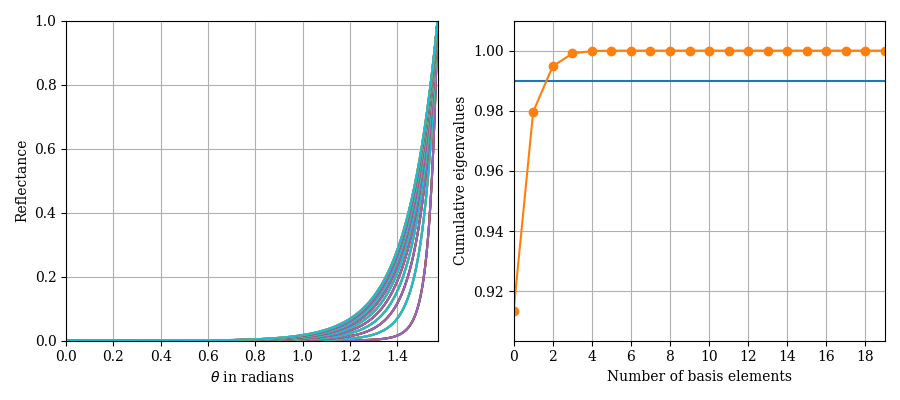

In [22]:
'''
    Compute the SVD for Fresnel curves and extract the eigenvalues
    
'''
nb_points = 1000
nb_IOR    = 100

'''
    We define the curves with respect to the elevation.
    For real-time implementation, it makes more sense to define
    since it avoids an acos call.
'''
cT        = np.linspace(0.0, 1.0, nb_points, endpoint=True)
T         = np.arccos(cT)

subrange  = np.linspace(0, nb_points-1, 20, dtype=int)
IOR       = np.linspace(1.01, 3.0, nb_IOR)
KAPPA     = np.zeros((nb_IOR, ))
curves    = np.ndarray( (nb_IOR, nb_points) )

for k,ior in enumerate(IOR):
    F  = ft.fresnel(cT, ior, KAPPA[k])
    R0 = ft.fresnel(1.0, ior, KAPPA[k])
    curves[k,:] = (F - R0) / (1.0-R0)

u, s, vh = np.linalg.svd(curves)
eigv = s[0:20] / np.sum(s)

'''
    Display the progression of eigenvalues
'''
fig, axs = plt.subplots(1, 2, figsize=(9,4))
handles = []
labels  = []

axs[0].grid()
axs[0].axis([0, 0.5*np.pi, 0, 1.0])
for k in np.linspace(0, 10, endpoint=False, dtype=int):
    handle, = axs[0].plot(T, curves[k, :])
axs[0].set_ylabel('Reflectance')
axs[0].set_xlabel(r'$\theta$ in radians')


axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[1].grid()
axs[1].axis([0, 19, eigv[0]-0.01, 1.01])
handle2, = axs[1].plot([0, 19], [0.99, 0.99])
handle1, = axs[1].plot(np.cumsum(eigv), marker='o')
axs[1].set_ylabel('Cumulative eigenvalues')
axs[1].set_xlabel(r'Number of basis elements')

plt.tight_layout()
plt.show()

As we can see, for dieletrics materials with $\eta \in [1.01, 3.0]$, only two basis elements different from the constant are required to correctly capture $99\%$ of the Fresnel reflectance curves' eigenvalues.

## Compute the Decomposition

In this Section, we compute our decomposition using a specific set of Index of Refractions (IORs). We used a thousand of different curves of both dielectric materials with $\eta_2 > \eta_1$ and conductors (spanned using the reflectivity / edge-tint parameterization) to build our decomposition.

Critical angle for basis2 =  0.12812812812812813 1.4423150071582151 82.63856263854684 128
Critical angle for basis3 =  0.43243243243243246 1.123607581568183 64.37797225275827 432


<IPython.core.display.Javascript object>


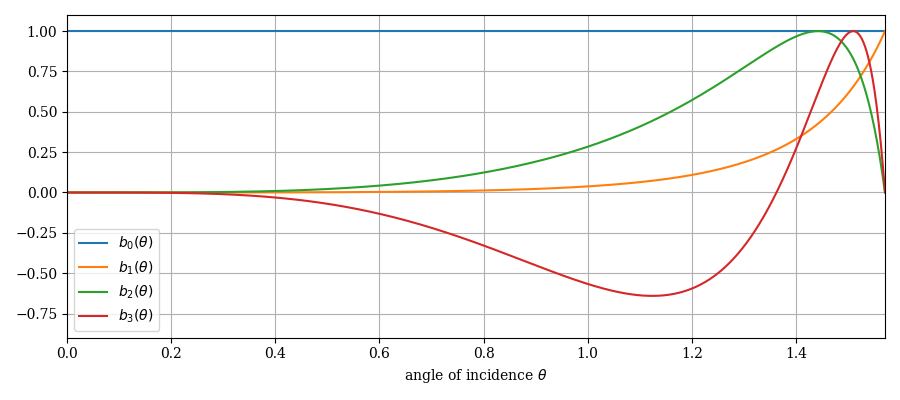

In [23]:
'''
    Compute the basis for Fresnel and define the projection operator.
    
'''
nb_points = 1000
nb_IOR    = 1000

'''
    Gulbrandsen conversion routines
    
    Gulbrandsen. Artist Friendly Metallic Fresnel. JCGT 2014.
    http://jcgt.org/published/0003/04/03/paper.pdf
    
    More details on it later.
'''
def RGtoNK2(r, g):
    if r == 0.0:
        return 1.0, 0.0
    n = g*(1.0-r)/(1.0+r) + (1.0-g)*(1.0+np.sqrt(r))/(1.0-np.sqrt(r))
    k2 = 0.0 if g<=0.0 else (r*(1.0+n)*(1.0+n) - (n-1.0)*(n-1.0)) / (1.0-r)
    return n, k2

def RGtoNK(r, g):
    n, k2 = RGtoNK2(r, g)
    return n, np.sqrt(k2)

'''
    We define the curves with respect to the elevation.
    For real-time implementation, it makes more sense to define
    since it avoids an acos call.
'''
cT        = np.linspace(0.0, 1.0, nb_points, endpoint=True)
T         = np.arccos(cT)

subrange  = np.linspace(0, nb_points-1, 20, dtype=int)
IOR       = np.linspace(1.1, 3.0, nb_IOR)
KAPPA     = np.zeros((nb_IOR, ))
curves    = np.ndarray( (IOR.shape[0], nb_points) )

'''
    We use a small percentage (1%) of conducting materials (g=1)
    and a large percentage (99%) of dieletrics to build the basis.
    This helps to better reconstruct both of them.
'''
alpha = 0.01
for k in range(1, nb_IOR):
    r = k / nb_IOR
    
    if r <= alpha:
        r = r/alpha
        r = (r) / (1.0-1.0E-5) + 1.0E-5
        g = 1.0
        IOR[k], KAPPA[k] = RGtoNK(r, g)
    else:
        r = (r - alpha)/(1.0-alpha)
        IOR[k], KAPPA[k] = 1.01+(3.0-1.01)*r,0.0

'''
    Build the Fresnel reflectance curves from the set of IOR
    set above. We remove F(0deg) from the curves and rescale
    it to map between 0 to 1.
'''    
for k,ior in enumerate(IOR):
    F  = ft.fresnel(cT, ior, KAPPA[k])
    R0 = ft.fresnel(1.0, ior, KAPPA[k])
    curves[k,:] = (F - R0) / (1.0-R0)

u, s, basis = np.linalg.svd(curves)

# Define the zeroth and first componnents
basis0 = np.ones_like(basis[0, :])
basis1 = np.abs(basis[0, :])
basis1 = basis1 / max(basis1)

for k,ior in enumerate(IOR):
    F  = ft.fresnel(cT, ior, KAPPA[k])
    R0 = ft.fresnel(1.0, ior, KAPPA[k])
    curves[k,:] = (F - R0)
    curves[k,:]  = curves[k,:]/(1.0-R0) - basis1
    
u, s, basis = np.linalg.svd(curves)

# Define the second and third componnents
basis2 = basis[0] / np.abs(basis[0]).max()
basis3 = basis[1] / np.abs(basis[1]).max()

i1  = np.argmax( basis2 )
t1  = T[ i1 ]
ct1 = cT[ i1 ]
print('Critical angle for basis2 = ', ct1, t1, 180.0/np.pi*t1, i1)

i2  = np.argmax( +basis3 )
i3  = np.argmax( -basis3 )
i2  = i2 if abs(i2-i1) > abs(i3-i1) else i3
t2  = T[ i2 ]
ct2 = cT[ i2 ]
print('Critical angle for basis3 = ', ct2, t2, 180.0/np.pi*t2, i2)

'''
    Define the projection operator that maps a complex IOR (eta+i*kappa)
    to the coefficients of the decomposition.
'''
def fresnel2coeffs(eta12, kappa=0.0):
    coeffs    = np.zeros((4))
    coeffs[0] = ft.fresnel(1.0, eta12, kappa)
    coeffs[1] = 1.0 - coeffs[0] if coeffs[0] else 0.0

    dF  = np.zeros((1,2))
    dF[0,0]  = ft.fresnel(ct1, eta12, kappa) - (coeffs[0] + coeffs[1]*basis1[i1])
    dF[0,1]  = ft.fresnel(ct2, eta12, kappa) - (coeffs[0] + coeffs[1]*basis1[i2])
    
    F12 = np.zeros((2,2))
    F12[0,0] = basis2[i1]
    F12[0,1] = basis2[i2]
    F12[1,0] = basis3[i1]
    F12[1,1] = basis3[i2]
    A = np.linalg.inv(F12)
    
    coeffs[2:4] = np.dot(dF, A)
    return coeffs


'''
    Display the basis elements and range of value for the coefficients for various
    values of eta and a dieletric material.
'''
plt.subplots(figsize=(9,4))
handles = []
labels  = []

plt.grid()
handle0, = plt.plot(T, basis0)
handle1, = plt.plot(T, basis1)
handle2, = plt.plot(T, basis2)
handle3, = plt.plot(T, basis3)
plt.legend([handle0, handle1, handle2, handle3], [r'$b_0(\theta)$', r'$b_1(\theta)$', r'$b_2(\theta)$', r'$b_3(\theta)$'])
plt.xlabel(r'angle of incidence $\theta$')
plt.axis([0, 0.5*np.pi, -0.9, 1.1])
plt.tight_layout()
plt.show()
# plt.savefig('../figures/basis.pdf')

<IPython.core.display.Javascript object>


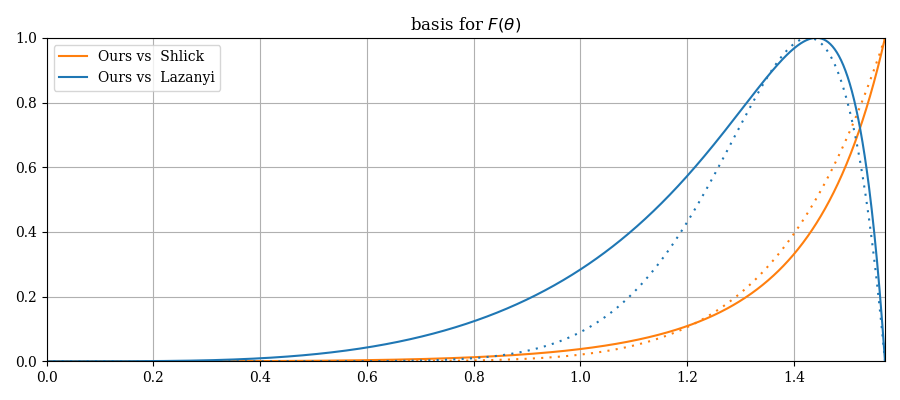

In [24]:
'''
    Compare the basis elements with the one of Shlick and Lazanyi.
'''
plt.subplots(ncols=1, figsize=(9,4))
handles   = []
labels    = []

plt.grid()
plt.title('basis for $F(\\theta)$')
handle, = plt.plot(T, basis1, color='C1')
handles += [handle]
labels  += ['Ours vs  Shlick']
plt.plot(T, np.power(1.0-cT, 5.0),  dashes=[1, 3], color='C1')

handle, = plt.plot(T, basis2)
handles += [handle]
labels  += ['Ours vs  Lazanyi']
lazanyi = cT * np.power(1.0-cT, 6.0)
plt.plot(T, lazanyi/lazanyi.max(), color=handle.get_color(), dashes=[1, 3])
plt.legend(handles, labels, loc='upper left')
plt.axis([0, 0.5*np.pi, 0.0, 1.0])
plt.tight_layout()
plt.show()

## Reconstruction of Fresnel Curves

In this Section, we use the decomposition defined above to fit different Fresnel curves. We start with dielectric materials, and then decompose conductors. Interestingly, and even though we did not use conductors to compute the decomposition, conductors are also well approximated by the decomposition.

<IPython.core.display.Javascript object>


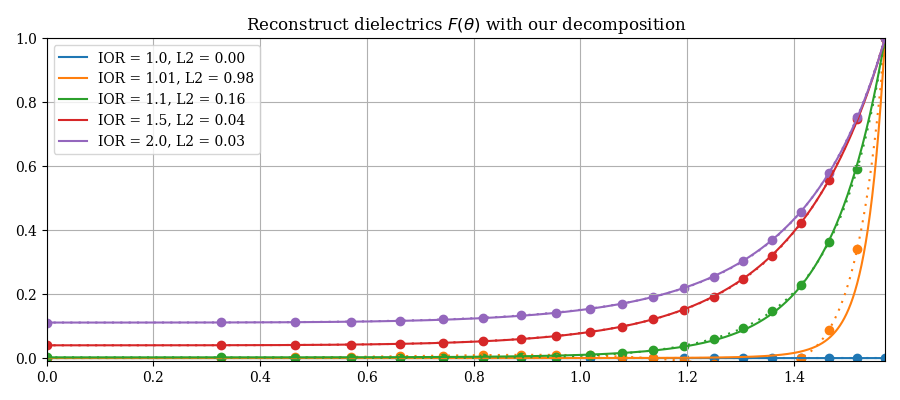

In [25]:
'''
    Display the fitting of dieletric reflectances
'''
plt.subplots(figsize=(9,4))
plt.grid()
handles = []
labels = []

for k,ior in enumerate([1.0, 1.01, 1.1, 1.5, 2.0]):
    F = ft.fresnel(cT, ior)
    handle, = plt.plot(T, F)
    handles.append(handle)
    
    coeffs = fresnel2coeffs(ior)
    P = coeffs[0] + coeffs[1]*basis1 + coeffs[2]*basis2 + coeffs[3]*basis3
    plt.scatter(T[subrange], P[subrange], color=handle.get_color(), marker='o')
    plt.plot(T, P, dashes=[1, 3], color=handle.get_color())
    
    L2 = np.linalg.norm(F-P)
    labels.append('IOR = ' + str(ior) + ', L2 = ' + f'{L2:.2f}')


plt.legend(handles, labels, loc='upper left')
plt.title('Reconstruct dielectrics $F(\\theta)$ with our decomposition')
plt.axis([0, 0.5*np.pi, -0.01, 1.0])
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


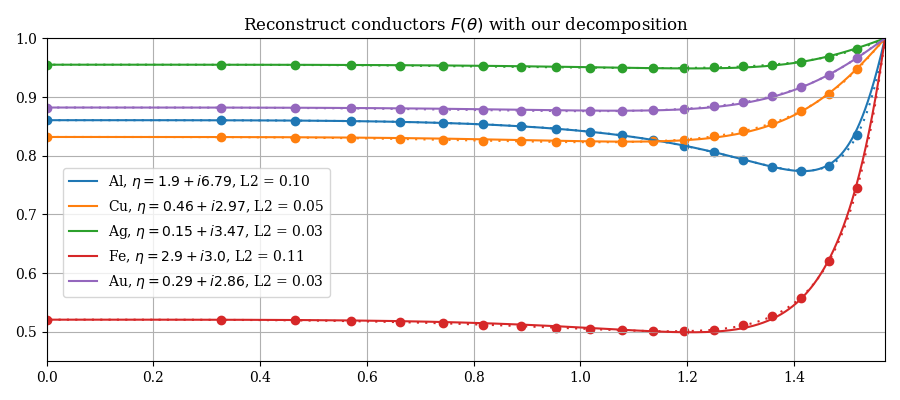

In [26]:
'''
    Display the fitting of conducting reflectances
'''
plt.subplots(figsize=(9,4))
plt.grid()

Etas   = [1.90, 0.46, 0.15, 2.9, 0.29]
Kappas = [6.79, 2.97, 3.47, 3.0, 2.86]
Titles = ['Al', 'Cu', 'Ag', 'Fe', 'Au']

handles = []
labels = []
for k,eta12 in enumerate(Etas):
    kappa = Kappas[k]
    F = ft.fresnel(cT, eta12, kappa)
    handle, = plt.plot(T, F)
    handles.append(handle)

    coeffs = fresnel2coeffs(eta12, kappa)
    P = coeffs[0] + coeffs[1]*basis1 + coeffs[2]*basis2 + coeffs[3]*basis3
    plt.scatter(T[subrange], P[subrange], color=handle.get_color(), marker='o')
    plt.plot(T, P, dashes=[1, 3], color=handle.get_color())
    
    L2 = np.linalg.norm(F-P)
    labels.append(Titles[k] + r', $\eta =  ' + str(eta12) + r' + i ' + str(kappa) + '$, L2 = ' + f'{L2:.2f}')

plt.legend(handles, labels, loc=(0.02, 0.2))
plt.axis([0, 0.5*np.pi, 0.45, 1.0])
plt.title('Reconstruct conductors $F(\\theta)$ with our decomposition')
plt.tight_layout()
plt.show()
# plt.savefig('../figures/reconstruct_conductors.pdf')

<IPython.core.display.Javascript object>


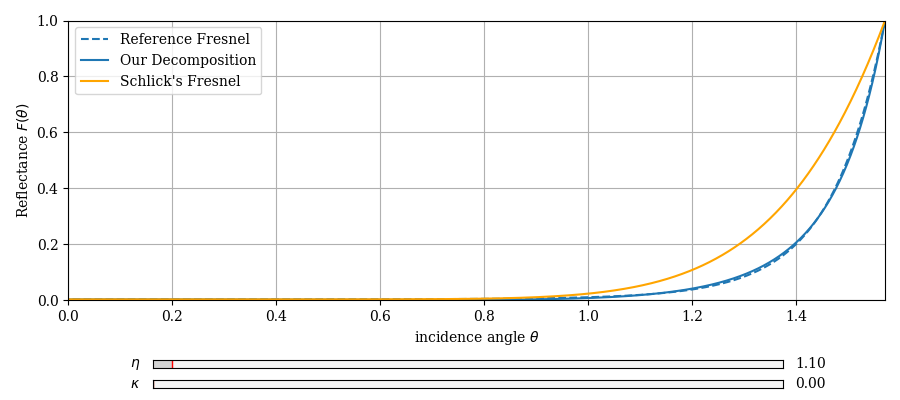

In [28]:
'''
    Interactive editing of the reflectance curve using the coefficients
'''
# Params for sliders     
HSLIDERS = 2; VSLIDERS = 1
INIT_VAL = [1.1, 0.0]; MIN_VAL = [1.01, 0.0]; MAX_VAL = [4.0, 4.0]
COLOR = ["lightgrey", "mediumaquamarine"]
LABELS = ["$\\eta$", "$\\kappa$"]
LENGTH, X, Y, BOTTOM = ft.init(HSLIDERS, VSLIDERS)    
    
# Start plot
START = 0.0; #START = np.pi/4.0-0.001

fig, ax = plt.subplots(figsize=(9,4))
plt.grid()

plt.axis([START, np.pi/2.0, 0, 1])
# plt.title("Fresnel along the isoline")
plt.xlabel("incidence angle $\\theta$")
plt.ylabel("Reflectance $F(\\theta)$")
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)

# Some interesting points
P = ft.fresnel(cT, INIT_VAL[0], INIT_VAL[1])
fresnel, = plt.plot(T, P, 'tab:blue', linestyle='--')
coeffs = fresnel2coeffs(INIT_VAL[0], INIT_VAL[1])
P = coeffs[0] + coeffs[1]*basis1 + coeffs[2]*basis2 + coeffs[3]*basis3
points,  = plt.plot(T, P, 'tab:blue')
P = coeffs[0] + (1.0-coeffs[0])*np.power(1.0-cT, 5.0)
schlick, = plt.plot(T, P, 'orange')
plt.legend(['Reference Fresnel', 'Our Decomposition', 'Schlick\'s Fresnel'])

# Add sliders
sliders = []
sliders.append(ft.add_slider(X[0], Y[0], INIT_VAL[0], LABELS[0], COLOR[0], LENGTH, MIN_VAL[0], MAX_VAL[0]))
sliders.append(ft.add_slider(X[0], Y[1], INIT_VAL[1], LABELS[1], COLOR[1], LENGTH, MIN_VAL[1], MAX_VAL[1]))

def update_coeffs(val):
    n = sliders[0].val
    k = sliders[1].val
    
    P = ft.fresnel(cT, n, k)
    fresnel.set_ydata(P)
    
    coeffs = fresnel2coeffs(n, k)
    P = coeffs[0] + coeffs[1]*basis1 + coeffs[2]*basis2 + coeffs[3]*basis3
    points.set_ydata(P)
    
    P = coeffs[0] + (1.0-coeffs[0])*np.power(1.0-cT, 5.0)
    schlick.set_ydata(P)
    
    
    fig.canvas.draw_idle()

sliders[0].on_changed(update_coeffs)
sliders[1].on_changed(update_coeffs)

plt.show()

## Gulbransen Parametrization

The Gulbransen parametrization map a couple $(r, g) \in [0,1]^2$ denoted *reflectivity* ($r$) and *edge-tint* ($g$) to the complex Index of Refraction $\eta + i\,\kappa$. This parametrization tries to provide an artistic mapping in a closed range that behave more linearly than the complex IOR. The parametrization is the following:

\begin{align}
    \eta   &= g \dfrac{1-r}{1+r} + \left(1-g\right)\dfrac{1+\sqrt{r}}{1-\sqrt{r}} \\
    \kappa &= \sqrt{\dfrac{1}{1-r}\left( r \, \left( 1+n \right)^2 - \left( n-1 \right)^2  \right)}
\end{align}

See [JCGT 2014 *Artist Friendly Metallic Fresnel*](http://jcgt.org/published/0003/04/03/paper.pdf)

<IPython.core.display.Javascript object>


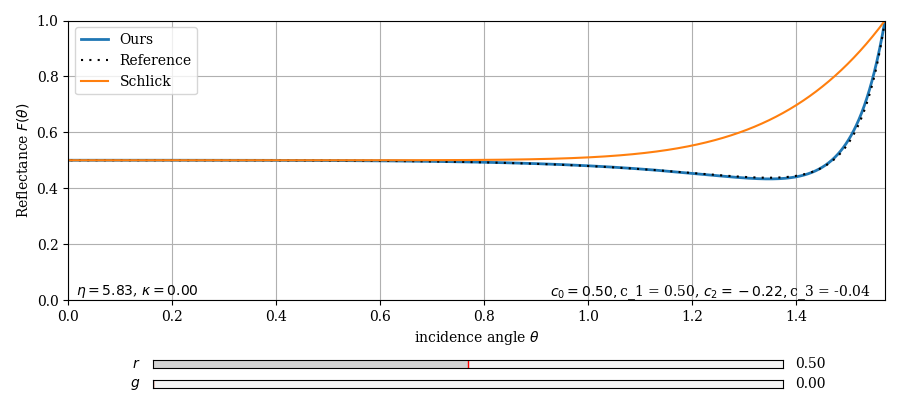

In [29]:
'''
    Interactive plot of Gulbransen's parametrization.
'''
R = np.linspace(0.0, 1.0, nb_IOR)
G = np.linspace(0.0, 1.0, nb_IOR)

# Params for sliders     
HSLIDERS = 2; VSLIDERS = 1
INIT_VAL = [0.5, 0.0, 0.0, 0.0]; MIN_VAL = [0.0, 0.0]; MAX_VAL = [1.0, 1.0]
COLOR = ["lightgrey", "mediumaquamarine"]
LABELS = ["$r$", "$g$"]
LENGTH, X, Y, BOTTOM = ft.init(HSLIDERS, VSLIDERS)    
    
# Start plot
START = 0.0; #START = np.pi/4.0-0.001

fig, ax = plt.subplots(figsize=(9,4))
plt.grid()
plt.subplots_adjust(bottom=BOTTOM)
plt.axis([START, np.pi/2.0, 0, 1])
plt.xlabel(r"incidence angle $\theta$")
plt.ylabel(r"Reflectance $F(\theta)$")
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)

# place a text box in upper left in axes coords
textstr = r'$\eta = 0$, $\kappa = 0$'
textbox = ax.text(0.01, 0.06, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top')
textstr2 = r'$c_0 = 0$, $c_1 = 0$, $c_2 = 0$, $c_3 = 0$'
textbox2 = ax.text(0.59, 0.06, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top')

# Some interesting points
coeffs = INIT_VAL
P = 0.0*basis3
points,  = plt.plot(T, P, linewidth=2)
refs,    = plt.plot(T, P, dashes=[1, 3], color='k')
schlick, = plt.plot(T, P)

labels = ['Ours', 'Reference', 'Schlick']
plt.legend([points, refs, schlick], labels, loc='upper left')
    
def update_rg(val):
    r, g = sliders[0].val, sliders[1].val
    n, k = RGtoNK(r, g)
    str_n = f"{n:.2f}"
    str_k = f"{k:.2f}"
    textstr = r'$\eta = ' + str_n + r'$, $\kappa = ' + str_k + '$'
    textbox.set_text(textstr)
    
    coeffs = fresnel2coeffs(n, k)
    resOurs = coeffs[0] + coeffs[1]*basis1 + coeffs[2]*basis2 + coeffs[3]*basis3
    points.set_ydata(resOurs)
    str_c0 = f"{coeffs[0]:.2f}"
    str_c1 = f"{coeffs[1]:.2f}"
    str_c2 = f"{coeffs[2]:.2f}"
    str_c3 = f"{coeffs[3]:.2f}"
    textstr = r'$c_0 = ' + str_c0 + r', $c_1 = ' + str_c1 + r', $c_2 = ' + str_c2 + r', $c_3 = ' + str_c3
    textbox2.set_text(textstr)
    
    res = ft.fresnel(cT, n, k)
    refs.set_ydata(res)
    
    resSchlick = sliders[0].val + (1.0-sliders[0].val)*np.power(1.0-cT, 5.0)
    schlick.set_ydata(resSchlick)
    
    fig.canvas.draw_idle()

# Add sliders
sliders = []
sliders.append(ft.add_slider(X[0], Y[0], INIT_VAL[0], LABELS[0], COLOR[0], LENGTH, MIN_VAL[0], MAX_VAL[0]))
sliders.append(ft.add_slider(X[0], Y[1], INIT_VAL[1], LABELS[1], COLOR[1], LENGTH, MIN_VAL[1], MAX_VAL[1]))
sliders[0].on_changed(update_rg)
sliders[1].on_changed(update_rg)
update_rg(0.0)

plt.show()

In the following, we study the effect of the Gulbrandsen's parametrization on the coefficients. Since the coefficients now behave linearly, we can use them to indicate if Gulbransen's mapping behave linearly for Fresnel reflectances. To do so, we are going to visualize the parameterization is the space of fitted coefficients $(c_0, c_2)$. Since $c_0$ is controlled by the reflectivity only, the spacing between points on the vertical $(c_2)$ axis will depict non-linear behaviours.

But first, we introduce a remapping of the $g$ parameter that is more linear:
\begin{align}
    \bar{g} = 1 - (1-g)^3
\end{align}

While we won't need this parametrization in the end but it will help to avoid aliasing issues when building our improved parametrization.

<IPython.core.display.Javascript object>


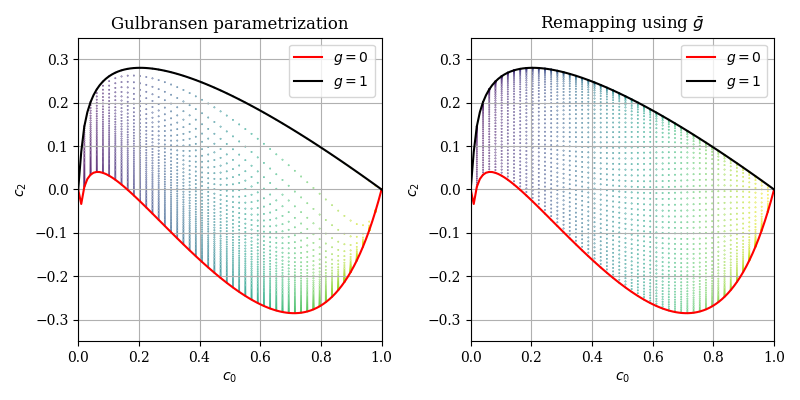

In [30]:
fig, axs = plt.subplots(1,2, figsize=(8,4))

nb_POINTS = 100
nb_RG = 50
NEAR_ONE = 1.0 - 1.0E-5

'''
    Generate two lines: one for the perfect dielectrics (g=0),
    and one for the maximum edge tint (g=1).
'''
R = np.linspace(0.00, NEAR_ONE, nb_POINTS)
c_diel = np.zeros((nb_POINTS, 4))
c_cond = np.zeros((nb_POINTS, 4))
for i,r in enumerate(R):
    [eta,kappa] = RGtoNK(r,0.0)
    c_diel[i,:] = fresnel2coeffs(eta, 0.0)
    [eta,kappa] = RGtoNK(r,1.0)
    c_cond[i,:] = fresnel2coeffs(eta, kappa)
    
'''
    Generate a grid of point, that provide the meshing of the
    space between the two curves using Gulbransen's
    parametrization.
'''
R = np.linspace(0.00, NEAR_ONE, nb_RG)
G = np.linspace(0.00, NEAR_ONE, nb_RG)
coeffs = np.zeros((nb_RG, nb_RG, 4))
for i, r in enumerate(R):
    for j, g in enumerate(G):
        [eta,kappa] = RGtoNK(r,g)
        coeffs[i,j,:] = fresnel2coeffs(eta, kappa)

ax = axs[0]
ax.scatter(coeffs[:,:,0], coeffs[:,:,2], c=coeffs[:,:,0], s=0.1)
ax.plot(c_diel[:,0], c_diel[:,2], c='red')
ax.plot(c_cond[:,0], c_cond[:,2], c='k')
# ax.plot(c_zero[:,0], c_zero[:,2], c='gray')
ax.set_xlabel('$c_0$')
ax.set_ylabel('$c_2$')
ax.grid()
ax.axis([0,1, -0.35, 0.35])
ax.legend(['$g=0$', '$g=1$'], loc='upper right')
ax.set_title('Gulbransen parametrization')

'''
    Generate a grid of point, that provide the meshing of the
    space between the two curves using a remapped Gulbransen's
    parametrization.
'''
R = np.linspace(0.00, NEAR_ONE, nb_RG)
g = np.linspace(0.00, NEAR_ONE, nb_RG)
coeffG = np.zeros((nb_RG, nb_RG, 4))
for i,r in enumerate(R):
    for j,g in enumerate(G):
        # empirical remapping
        g = 1.0-pow(1.0-g,3)
        [eta,k2] = RGtoNK2(r,g)
        coeffG[i,j,:] = fresnel2coeffs(eta, np.sqrt(k2))

ax = axs[1]
ax.scatter(coeffG[:,:,0], coeffG[:,:,2], c=coeffG[:,:,0], s=0.1)
ax.plot(c_diel[:,0], c_diel[:,2], c='red')
ax.plot(c_cond[:,0], c_cond[:,2], c='k')
ax.set_xlabel('$c_0$')
ax.set_ylabel('$c_2$')
ax.grid()
ax.axis([0,1, -0.35, 0.35])
ax.legend(['$g=0$', '$g=1$'], loc='upper right')
ax.set_title('Remapping using $\\bar{g}$')

plt.tight_layout()
plt.show()

This remapping of the Gulbransen parametrization is still not satisfactory: we can see compressions close to the $g = 0$ and $g= 1$ curves.

Such compressions are also visible when visualizing the manifold in 3D.

<IPython.core.display.Javascript object>


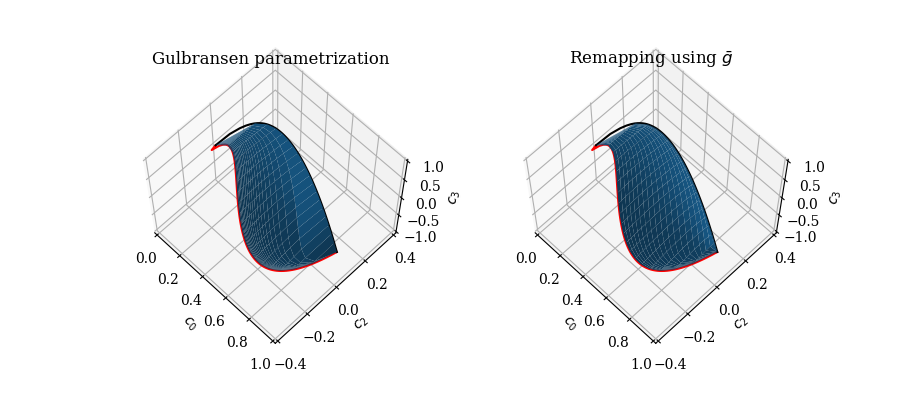

In [31]:
fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(121, projection='3d')

nb_RG = 20


'''
    Generate the manifold of the coefficients using Gulbransen's
    parametrization.
'''
R = np.linspace(0.0, NEAR_ONE, nb_RG)
G = np.linspace(0.0, 1.0, nb_RG)
coeffs = np.zeros((nb_RG, nb_RG, 4))
for i, r in enumerate(R):
    for j, g in enumerate(G):
        [eta,kappa] = RGtoNK(r,g)
        coeffs[i,j,:] = fresnel2coeffs(eta, kappa)

ax.plot_surface(coeffs[:,:,0], coeffs[:,:,2], coeffs[:,:,3])
ax.plot(c_diel[:,0], c_diel[:,2], c_diel[:,3], 'r')
ax.plot(c_cond[:,0], c_cond[:,2], c_cond[:,3], 'k')
ax.view_init(elev=65., azim=-45)

ax.set_xlabel('$c_0$')
ax.set_ylabel('$c_2$')
ax.set_zlabel('$c_3$')
ax.set_xlim(0,1)
ax.set_ylim(-0.4,0.4)
ax.set_zlim(-1,1)
ax.set_title('Gulbransen parametrization')


ax = fig.add_subplot(122, projection='3d')

'''
    Generate two lines: one for the perfect dielectrics (g=0),
    and one for the maximum edge tint (g=1).
'''
R = np.linspace(0.0, NEAR_ONE, nb_POINTS)
c_diel = np.zeros((nb_POINTS, 4))
c_cond = np.zeros((nb_POINTS, 4))
for i,r in enumerate(R):
    [eta,kappa] = RGtoNK(r,0.0)
    c_diel[i,:] = fresnel2coeffs(eta, 0.0)
    [eta,kappa] = RGtoNK(r,1.0)
    c_cond[i,:] = fresnel2coeffs(eta, kappa)


'''
    Generate the manifold of the coefficients using the updated
    parametrization.
'''
R = np.linspace(0.0, NEAR_ONE, nb_RG)
g = np.linspace(0.0, 1.0, nb_RG)
coeffG = np.zeros((nb_RG, nb_RG, 4))
for i,r in enumerate(R):
    for j,g in enumerate(G):
        # empirical remapping
        g = 1.0-pow(1.0-g,3)
        [eta,k2] = RGtoNK2(r,g)
        coeffG[i,j,:] = fresnel2coeffs(eta, np.sqrt(k2))
        

ax.plot(c_diel[:,0], c_diel[:,2], c_diel[:,3], 'r')
ax.plot(c_cond[:,0], c_cond[:,2], c_cond[:,3], 'k')
ax.plot_surface(coeffG[:,:,0], coeffG[:,:,2], coeffG[:,:,3])
ax.view_init(elev=65., azim=-45)

ax.set_xlabel('$c_0$')
ax.set_ylabel('$c_2$')
ax.set_zlabel('$c_3$')
ax.set_xlim(0,1)
ax.set_ylim(-0.4,0.4)
ax.set_zlim(-1,1)
ax.set_title('Remapping using $\\bar{g}$')

plt.show()

## Improved Mapping

We can further improve Gulbransen's mapping by using a custom mapping where we interpolate between the curves $g=0$ and $g=1$ with an interpolation parameter $\beta$.

Since $c_0$ and $c_1$ are fully determined by the $r$ parameter. Let $(c_2, c_3) = M_1(r)$ the curve of the parameters for $g=1$. Let $(c_2, c_3) = M_0(r)$, the curve of the parameters for $g=0$.

We find $c_2$ using a linear interpolation between $M_0$ and $M_1$ with a parameter $\beta$:
\begin{align}
    c_2 = \beta M_0 + (1 - \beta) M_1
\end{align}

The last coefficient $c_3$ is given as a function of $c_0$ and $c_2$:
$$c_3 = D(c_0, c_2)$$
Note that this is equivalent to being defined as a function of $r$ and $\beta$.

In [34]:
'''
    This class permits to convert (r, 𝛽) to (c2, c3)
'''
NEAR_ONE = 1.0-1.0E-5

class NewMapping:
    # Constructor create the c_diel and c_cond curves
    # that correspond to (r, 0) and (r, 1) curves.
    # Data is discretized using `nb_POINTS`.
    def __init__(self, nb_COEFFS=256):
        # Generate the `c_diel` and `c_cond` curves
        self.c_R    = np.linspace(0, NEAR_ONE, nb_COEFFS)
        self.c_diel = np.zeros((nb_COEFFS, 4))
        self.c_cond = np.zeros((nb_COEFFS, 4))
        for i,r in enumerate(self.c_R):
            [eta,kappa] = RGtoNK(r, 0.0)
            self.c_diel[i,:] = fresnel2coeffs(eta, kappa)
            [eta,kappa] = RGtoNK(r, 1.0)
            self.c_cond[i,:] = fresnel2coeffs(eta, kappa)
            
        # Generate the map of points
        self.mapping_R = np.linspace(0, NEAR_ONE, nb_COEFFS)
        self.mapping_B = np.linspace(0, 1, nb_COEFFS)
        coeffs = np.zeros((nb_COEFFS, nb_COEFFS, 4))
        for i,r in enumerate(self.mapping_R):
            for j,g in enumerate(self.mapping_B):
                g = 1.0-pow(1.0-g,3)
                [eta,kappa] = RGtoNK(r, g)
                coeffs[i,j,:] = fresnel2coeffs(eta, kappa)

        # Generate the mapping from r, c2 -> c3
        self.mapping = np.ones((nb_COEFFS, nb_COEFFS))
        for i,r in enumerate(self.mapping_R):
            
            #'''
            for j,𝛽 in enumerate(self.mapping_B):
                values = (1-𝛽)*self.c_diel[i,2] + (𝛽)*self.c_cond[i,2]
                
                indice = np.searchsorted(coeffs[i,:,2], values, 'right')
                indice = min(indice, nb_COEFFS-1)
                self.mapping[i,j] = coeffs[i, indice, 3]              
    
    def c2(self, r, 𝛽):
        i  = int(r * (self.c_diel.shape[0]-1))
        c_diel = np.interp(r, self.c_R, self.c_diel[:,2])
        c_cond = np.interp(r, self.c_R, self.c_cond[:,2])
        c2 = (1-𝛽)*c_diel + (𝛽)*c_cond
        return c2
    
    def c3(self, r, 𝛽):
        i  = int(r * (self.mapping.shape[0]-1))
        j  = int(𝛽 * (self.mapping.shape[0]-1))
        c3 = self.mapping[i, j]
        return c3    

    def __call__(self, r, 𝛽):
        return self.c2(r, 𝛽), self.c3(r, 𝛽)

CoeffsFromRBeta = NewMapping()

<IPython.core.display.Javascript object>


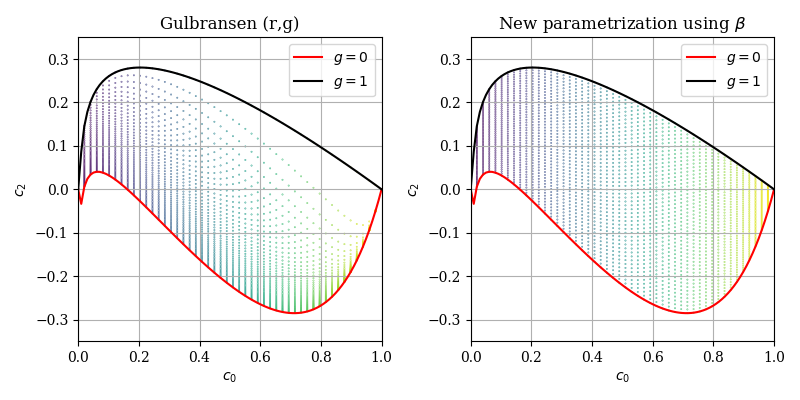

In [35]:
'''
    Plot the (c0,c2) parametrization using the (r,𝛽) mapping.
    Compare to the better Gulbransen.
'''
fig, axs = plt.subplots(1,2, figsize=(8,4))

nb_POINTS = 100
nb_RG = 50


'''
    Generate two lines: one for the perfect dielectrics (g=0),
    and one for the maximum edge tint (g=1).
'''
R = np.linspace(0.00, NEAR_ONE, nb_POINTS)
c_diel = np.zeros((nb_POINTS, 4))
c_cond = np.zeros((nb_POINTS, 4))
for i,r in enumerate(R):
    [eta,kappa] = RGtoNK(r,0.0)
    c_diel[i,:] = fresnel2coeffs(eta, 0.0)
    [eta,kappa] = RGtoNK(r,1.0)
    c_cond[i,:] = fresnel2coeffs(eta, kappa)
    
'''
    Generate a grid of point, that provide the meshing of the
    space between the two curves using Gulbransen's
    parametrization.
'''
R = np.linspace(0.00, NEAR_ONE, nb_RG)
G = np.linspace(0.00, 1.0, nb_RG)
coeffs = np.zeros((nb_RG, nb_RG, 4))
for i, r in enumerate(R):
    for j, g in enumerate(G):
        # empirical remapping
#         g = 1.0-pow(1.0-g,3)
        [eta,k2] = RGtoNK2(r,g)
        coeffs[i,j,:] = fresnel2coeffs(eta, np.sqrt(k2))
        
ax = axs[0]
ax.scatter(coeffs[:,:,0], coeffs[:,:,2], c=coeffs[:,:,0], s=0.1)
ax.plot(c_diel[:,0], c_diel[:,2], c='red')
ax.plot(c_cond[:,0], c_cond[:,2], c='k')
ax.set_xlabel('$c_0$')
ax.set_ylabel('$c_2$')
ax.grid()
ax.axis([0,1, -0.35, 0.35])
ax.legend(['$g=0$', '$g=1$'], loc='upper right')
ax.set_title('Gulbransen (r,g)')

'''
    Generate a grid of point, that provide the meshing of the
    space between the two curves using a remapped Gulbransen's
    parametrization.
'''
R = np.linspace(0.00, NEAR_ONE, nb_RG)
g = np.linspace(0.00, 1.0, nb_RG)
coeffG = np.zeros((nb_RG, nb_RG, 4))
for i,r in enumerate(R):
    for j,g in enumerate(G):
        coeffG[i,j,0] = r
        coeffG[i,j,1] = 1-r
        coeffG[i,j,2], coeffG[i,j,3] = CoeffsFromRBeta(r, g)
        
ax = axs[1]
ax.scatter(coeffG[:,:,0], coeffG[:,:,2], c=coeffG[:,:,0], s=0.1)
ax.plot(c_diel[:,0], c_diel[:,2], c='red')
ax.plot(c_cond[:,0], c_cond[:,2], c='k')
ax.set_xlabel('$c_0$')
ax.set_ylabel('$c_2$')
ax.grid()
ax.axis([0,1, -0.35, 0.35])
ax.legend(['$g=0$', '$g=1$'], loc='upper right')
ax.set_title('New parametrization using $\\beta$')

plt.tight_layout()
plt.show()

Our new parametrization with $\beta$ improves on the simple remapping $\bar{g}$ of the Gulbransen parametrization. As we can see above, there are not longer compression close to the $g=0$ and $g=1$ regions.

We can also vizualize that the manifold of coefficients is more regular.

<IPython.core.display.Javascript object>


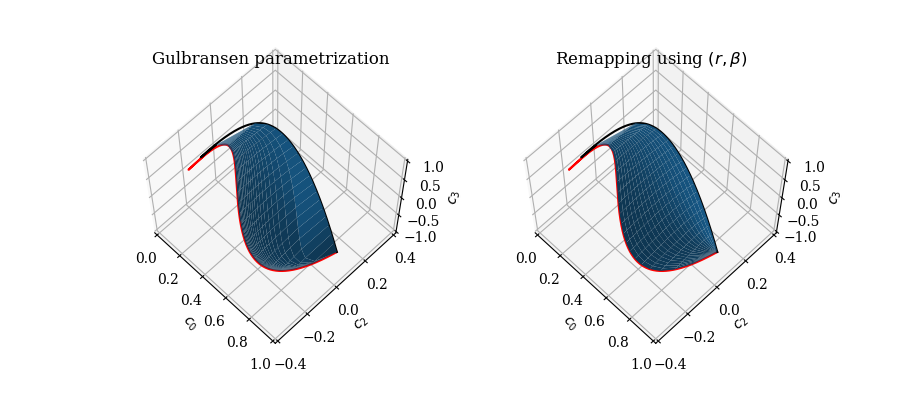

In [36]:
fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(121, projection='3d')

nb_POINTS = 1000
nb_RG = 20

'''
    Generate two lines: one for the perfect dielectrics (g=0),
    and one for the maximum edge tint (g=1).
'''
R = np.linspace(0.00, NEAR_ONE, nb_POINTS)
c_diel = np.zeros((nb_POINTS, 4))
c_cond = np.zeros((nb_POINTS, 4))
for i,r in enumerate(R):
    [eta,kappa] = RGtoNK(r,0.0)
    c_diel[i,:] = fresnel2coeffs(eta, 0.0)
    [eta,kappa] = RGtoNK(r,1.0)
    c_cond[i,:] = fresnel2coeffs(eta, kappa)

'''
    Generate the manifold of the coefficients using Gulbransen's
    parametrization.
'''
R = np.linspace(0.00, NEAR_ONE, nb_RG)
G = np.linspace(0.00, 1.0, nb_RG)
coeffs = np.zeros((nb_RG, nb_RG, 4))
for i, r in enumerate(R):
    for j, g in enumerate(G):
        [eta,kappa] = RGtoNK(r,g)
        coeffs[i,j,:] = fresnel2coeffs(eta, kappa)

ax.plot_surface(coeffs[:,:,0], coeffs[:,:,2], coeffs[:,:,3])
ax.plot(c_diel[:,0], c_diel[:,2], c_diel[:,3], 'r')
ax.plot(c_cond[:,0], c_cond[:,2], c_cond[:,3], 'k')
ax.view_init(elev=65., azim=-45)

ax.set_xlabel('$c_0$')
ax.set_ylabel('$c_2$')
ax.set_zlabel('$c_3$')
ax.set_xlim(0,1)
ax.set_ylim(-0.4,0.4)
ax.set_zlim(-1,1)
ax.set_title('Gulbransen parametrization')


ax = fig.add_subplot(122, projection='3d')

'''
    Generate two lines: one for the perfect dielectrics (g=0),
    and one for the maximum edge tint (g=1).
'''
R = np.linspace(0.00, NEAR_ONE, nb_POINTS)
c_diel = np.zeros((nb_POINTS, 4))
c_cond = np.zeros((nb_POINTS, 4))
for i,r in enumerate(R):
    [eta,kappa] = RGtoNK(r,0.0)
    c_diel[i,:] = fresnel2coeffs(eta, 0.0)
    [eta,kappa] = RGtoNK(r,1.0)
    c_cond[i,:] = fresnel2coeffs(eta, kappa)


'''
    Generate the manifold of the coefficients using the (r,𝛽) parametrization.
'''
R = np.linspace(0.00, 1.0, nb_RG)
g = np.linspace(0.00, 1.0, nb_RG)
coeffG = np.zeros((nb_RG, nb_RG, 4))
for i,r in enumerate(R):
    for j,g in enumerate(G):
        coeffG[i,j,0] = r
        coeffG[i,j,1] = 1-r
        coeffG[i,j,2], coeffG[i,j,3] = CoeffsFromRBeta(r, g)
        

ax.plot(c_diel[:,0], c_diel[:,2], c_diel[:,3], 'r')
ax.plot(c_cond[:,0], c_cond[:,2], c_cond[:,3], 'k')
ax.plot_surface(coeffG[:,:,0], coeffG[:,:,2], coeffG[:,:,3])
ax.view_init(elev=65., azim=-45)

ax.set_xlabel('$c_0$')
ax.set_ylabel('$c_2$')
ax.set_zlabel('$c_3$')
ax.set_xlim(0,1)
ax.set_ylim(-0.4,0.4)
ax.set_zlim(-1,1)
ax.set_title('Remapping using $(r,\\beta)$')

plt.show()

In the following figure, we visualize the mapping for coefficients $c_2$ and $c_3$ for both Gulbrandsen's parameterization (top row) and our new parameterization (bottom row).

<IPython.core.display.Javascript object>


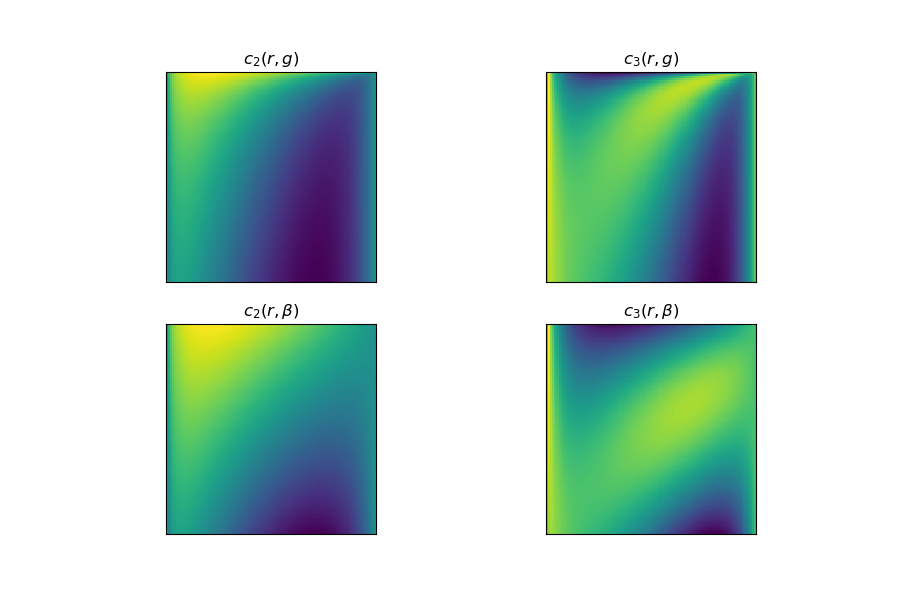

In [37]:
fig, ax = plt.subplots(2, 2, figsize=(9,6))

'''
    Generate the c2(r,g) and c3(r,g) image.
'''
nb_RG = 100
R = np.linspace(0.00, NEAR_ONE, nb_RG)
G = np.linspace(0.00, 1.0, nb_RG)
coeffs = np.zeros((nb_RG, nb_RG, 4))
for i, r in enumerate(R):
    for j, g in enumerate(G):
        [eta,kappa] = RGtoNK(r,g)
        coeffs[i,j,:] = fresnel2coeffs(eta, kappa)

plt.subplot(2, 2, 1)
imC2G = plt.imshow(np.transpose(coeffs[:,:,2]),origin='lower')
plt.xticks([])
plt.yticks([])
plt.title('$c_2(r,g)$')

plt.subplot(2, 2, 2)
imC3G = plt.imshow(np.transpose(coeffs[:,:,3]),origin='lower')
plt.xticks([])
plt.yticks([])
plt.title('$c_3(r,g)$')

'''
    Generate the c2(r,𝛽) and c3(r,𝛽) image.
'''
coeffs = np.zeros((nb_RG, nb_RG, 4))
for i, r in enumerate(R):
    for j, g in enumerate(G):
        coeffs[i,j,0] = r
        coeffs[i,j,1] = 1-r
        coeffs[i,j,2], coeffs[i,j,3] = CoeffsFromRBeta(r, g)
        
plt.subplot(2, 2, 3)
imC2Beta = plt.imshow(np.transpose(coeffs[:,:,2]),origin='lower')
plt.xticks([])
plt.yticks([])
plt.title('$c_2(r,\\beta)$')

plt.subplot(2, 2, 4)
imC3Beta = plt.imshow(np.transpose(coeffs[:,:,3]),origin='lower')
plt.xticks([])
plt.yticks([])
plt.title('$c_3(r,\\beta)$')
plt.show()

<IPython.core.display.Javascript object>


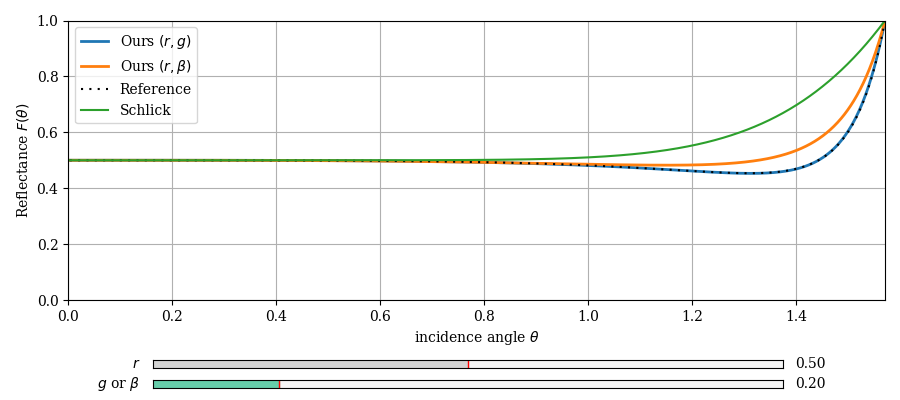

In [38]:
'''
    Interactive comparison of Gulbransen's parametrization (r,g) and
    the new parametrization (r,𝛽).
    
    Here, we advise to focus on the linearity of the control of the
    curve.
'''
R = np.linspace(0.0, NEAR_ONE, nb_IOR)
G = np.linspace(0.0, 1.0, nb_IOR)

# Params for sliders     
HSLIDERS = 2; VSLIDERS = 1
INIT_VAL = [0.5, 0.2, 0.0, 0.0]; MIN_VAL = [0.0, 0.0]; MAX_VAL = [1.0, 1.0]
COLOR = ["lightgrey", "mediumaquamarine"]
LABELS = ["$r$", "$g$ or $\\beta$"]
LENGTH, X, Y, BOTTOM = ft.init(HSLIDERS, VSLIDERS)    
    
# Start plot
START = 0.0; #START = np.pi/4.0-0.001

fig, ax = plt.subplots(figsize=(9,4))
plt.grid()
plt.subplots_adjust(bottom=BOTTOM)
plt.axis([START, np.pi/2.0, 0, 1])
plt.xlabel(r"incidence angle $\theta$")
plt.ylabel(r"Reflectance $F(\theta)$")
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)

# Some interesting points
coeffs = INIT_VAL
P = 0.0*basis3
points,  = plt.plot(T, P, linewidth=2)
pointsLin,  = plt.plot(T, P, linewidth=2)
refs,    = plt.plot(T, P, dashes=[1, 3], color='k')
schlick, = plt.plot(T, INIT_VAL[0] + (1.0-INIT_VAL[0])*np.power(1.0-cT, 5.0))

labels = ['Ours $(r,g)$', 'Ours $(r,\\beta)$', 'Reference', 'Schlick']
plt.legend([points, pointsLin, refs, schlick], labels, loc='upper left')
    
def update_rg(val):
    r, g = sliders[0].val, sliders[1].val
    n, k = RGtoNK(r, g)
   
    coeffs = fresnel2coeffs(n, k)
    resOurs = coeffs[0] + coeffs[1]*basis1 + coeffs[2]*basis2 + coeffs[3]*basis3
    points.set_ydata(resOurs)

    coeffs[0] = r
    coeffs[1] = 1-r
    coeffs[2], coeffs[3] = CoeffsFromRBeta(r, g)
    resOursLin = coeffs[0] + coeffs[1]*basis1 + coeffs[2]*basis2 + coeffs[3]*basis3
    pointsLin.set_ydata(resOursLin)
    
    res = ft.fresnel(cT, n, k)
    refs.set_ydata(res)
    
    resSchlick = sliders[0].val + (1.0-sliders[0].val)*np.power(1.0-cT, 5.0)
    schlick.set_ydata(resSchlick)
    
    fig.canvas.draw_idle()

# Add sliders
sliders = []
sliders.append(ft.add_slider(X[0], Y[0], INIT_VAL[0], LABELS[0], COLOR[0], LENGTH, MIN_VAL[0], MAX_VAL[0]))
sliders.append(ft.add_slider(X[0], Y[1], INIT_VAL[1], LABELS[1], COLOR[1], LENGTH, MIN_VAL[1], MAX_VAL[1]))
sliders[0].on_changed(update_rg)
sliders[1].on_changed(update_rg)
update_rg(0.0)

plt.show()

## Default $\beta$

We might want to have a default setting of $\beta$ that provide a close to Schlick behaviour. Here, we test different schemes:

  + One that uses a fixed $\beta$ whatever the input $r$ is. We found that $\beta = 0.75$ to be a good match.
  + One that optimize a function $\beta_{opt}(r)$ to provide the smallest $c_2$ and $c_3$ with respect to the L2-norm.

<IPython.core.display.Javascript object>


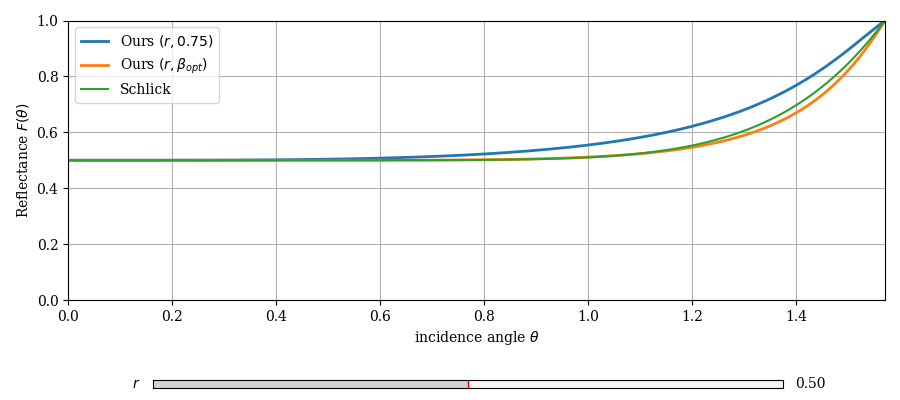

In [39]:
'''
    Interactive comparison between Schlick's Fresnel and the mapping
    where we select the min of c2 and c3.
'''
R = np.linspace(0.0, NEAR_ONE, nb_IOR)
G = np.linspace(0.0, 1.0, nb_IOR)

# Params for sliders     
HSLIDERS = 1; VSLIDERS = 1
INIT_VAL = [0.5, 0.2, 0.0, 0.0]; MIN_VAL = [0.0, 0.0]; MAX_VAL = [1.0, 1.0]
COLOR = ["lightgrey", "mediumaquamarine"]
LABELS = ["$r$", "$g$ or $\\beta$"]
LENGTH, X, Y, BOTTOM = ft.init(HSLIDERS, VSLIDERS)    
    
# Start plot
START = 0.0; #START = np.pi/4.0-0.001

fig, ax = plt.subplots(figsize=(9,4))
plt.grid()
plt.subplots_adjust(bottom=BOTTOM)
plt.axis([START, np.pi/2.0, 0, 1])
plt.xlabel(r"incidence angle $\theta$")
plt.ylabel(r"Reflectance $F(\theta)$")
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)

# Some interesting points
coeffs = INIT_VAL
P = 0.0*basis3
pts1,  = plt.plot(T, P, linewidth=2)
pts2,  = plt.plot(T, P, linewidth=2)
schlick, = plt.plot(T, INIT_VAL[0] + (1.0-INIT_VAL[0])*np.power(1.0-cT, 5.0))

labels = ['Ours $(r,0.75)$', 'Ours $(r,\\beta_{opt})$','Schlick']
plt.legend([pts1, pts2, schlick], labels, loc='upper left')

NB_R = 256
beta_opt = np.zeros((NB_R, 1))
temp_c23 = np.zeros((NB_R, 1))
for k in range(NB_R):
    r = k / NB_R
    for l in range(NB_R):
        b = l / NB_R
        t_c2, t_c3 = CoeffsFromRBeta(r, b)
        temp_c23[l] = t_c2*t_c2 + t_c3*t_c3
    beta_opt[k] = np.argmin(temp_c23) / NB_R
    

def update_rg(val):
    r = sliders[0].val

    # Fixed beta
    coeffs[2], coeffs[3] = CoeffsFromRBeta(r, 0.75)
    P = r + (1-r)*basis1 + coeffs[2]*basis2 + coeffs[3]*basis3
    pts1.set_ydata(P)

    # Search for the optimal beta
    coeffs[2], coeffs[3] = CoeffsFromRBeta(r, beta_opt[int(r * NB_R)])
    P = r + (1-r)*basis1 + coeffs[2]*basis2 + coeffs[3]*basis3
    pts2.set_ydata(P)
    
    # Reference Schlick
    P = r + (1.0-r)*np.power(1.0-cT, 5.0)
    schlick.set_ydata(P)
    
    fig.canvas.draw_idle()

# Add sliders
sliders = []
sliders.append(ft.add_slider(X[0], Y[0], INIT_VAL[0], LABELS[0], COLOR[0], LENGTH, MIN_VAL[0], MAX_VAL[0]))
sliders[0].on_changed(update_rg)
update_rg(0.0)

plt.show()

## Validation on Measured Materials

Here, we plot a comparison of our model with respect to the ground truth Fresnel and Schlick's approximation when fitting measured Index of Refractions (IOR) from [refractiveindex.info](http://refractiveindex.info) using the pre-integration method of Mitsuba.

<IPython.core.display.Javascript object>


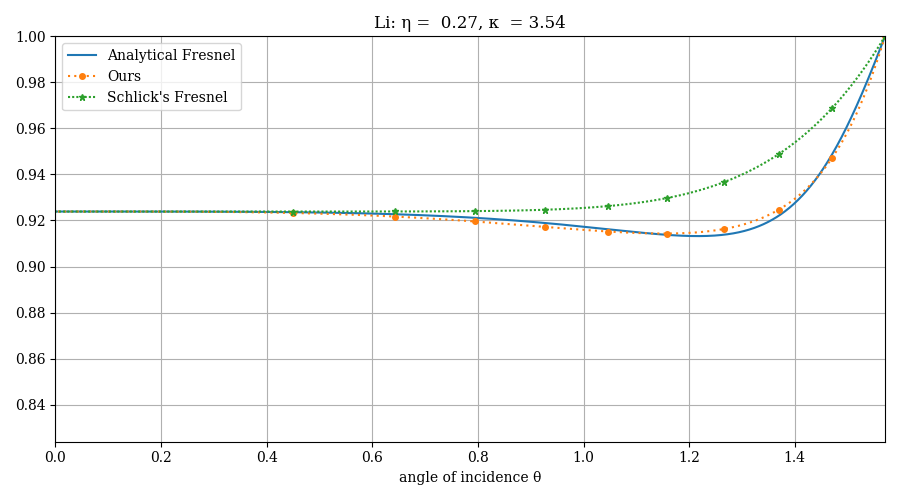

In [41]:
materials = {
#     'Au': {
#         'eta': [ 0.143245,  0.377423,  1.43919 ],
#         'kappa': [ 3.98479,  2.3847,   1.60434]
#     },
#     'Ag': {
#         'eta': [ 0.15554,   0.11678,  0.138371],
#         'kappa': [ 4.83139,  3.12331,  2.14745]
#     },
#     'Al': {
#         'eta': [ 1.66058,   0.88143,   0.521467],
#         'kappa': [ 9.2282,   6.27077,  4.83803]
#     },
#     'Be': {
#         'eta': [ 4.17289,  3.1856,   2.78507],
#         'kappa': [ 3.84821,  3.00922,  2.868  ]
#     },
#     'Li': {
#         'eta': [ 0.269479,  0.20043,   0.22334 ],
#         'kappa': [ 3.54258,  2.35127,  1.68649]
#     },
#     'Cu': {
#         'eta': [ 0.208183,  0.919438,  1.10241 ],
#         'kappa': [ 3.92198,  2.45627,  2.14157]
#     },
#     'Cr': {
#         'eta': [ 4.48917,  2.90664,  1.66205],
#         'kappa': [ 5.21625,  4.22766,  3.75206]
#     },
#     'Ni_palik': {
#         'eta': [ 2.36536,  1.66554,  1.46775],
#         'kappa': [ 4.48998,  3.05435,  2.34784]
#     },
#     'Rh': {
#         'eta': [ 2.59175,  1.86153,  1.54991],
#         'kappa': [ 6.79406,  4.70807,  3.97543]
#     },
#     'W': {
#         'eta': [ 4.37329,  3.3001,   2.99905],
#         'kappa': [ 3.50037,  2.60519,  2.2736 ]
#     },
#     'V_palik': {
#         'eta': [ 4.27784,  3.50396,  2.76413],
#         'kappa': [ 3.50274,  2.89113,  3.10682]
#     },
    'Li': {
        'eta': [ 0.269479,  0.20043,   0.22334 ],
        'kappa': [ 3.54258,  2.35127,  1.68649]
    },
#     'a-C': {
#         'eta': [ 2.9304,   2.22903,  1.9696 ],
#         'kappa': [ 0.892391,  0.791871,  0.815725]
#     }
}

Colors = ['#FA5858', '#01DF3A', '#58ACFA']

for material in materials:
    plt.subplots(figsize=(9.0,5.0))
    plt.grid()

    Etas   = materials[material]['eta']
    Kappas = materials[material]['kappa']

    handles = []
    labels = []
    eta = Etas[0]
    kappa = Kappas[0]
    F = ft.fresnel(cT, eta, kappa)
    handle, = plt.plot(T, F)
    handles.append(handle)
    labels.append('Analytical Fresnel')

    coeffs = fresnel2coeffs(eta, kappa)

    P = coeffs[0] + coeffs[1]*basis1 + coeffs[2]*basis2 + coeffs[3]*basis3
    handle, = plt.plot(T, P, dashes=[1, 2], marker='o', markevery=100, markersize=4)
    handles.append(handle)
    labels.append('Ours')
    

    P = coeffs[0] + (1.0-coeffs[0])*np.power(1 - cT, 5)
    handle, = plt.plot(T, P, dashes=[1, 1], marker='*', markevery=100, markersize=5)
    handles.append(handle)
    labels.append('Schlick\'s Fresnel')

    textstr = material + r': η =  ' + f'{eta:.2f}' + r', κ  = ' + f'{kappa:.2f}'
    plt.title(textstr)
    plt.xlabel(r'angle of incidence θ')
    plt.legend(labels)
    maxF = max(0.0, np.min(P)-0.1)
    plt.axis([0.0, np.pi*0.5, maxF, 1.0])
    plt.tight_layout()
plt.show()